# Tennis stroke classification with ML

This project details how to classify a tennis player stroke with Machine Learning with data gathered from an Apple Watch.

The application required to gather this data is [link text](https://). It needs the following REST API to export data from the device: [link text](https://).

It's recommended to run this notebook at [Google Colab](https://colab.research.google.com), where it's built.

In [2]:
#@title
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import matplotlib.ticker as plticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


## Loading data

Data is loaded from JSON files. Each of them is a list of sensor data from the device at a given timestamp.

In [3]:
# Check files to load
folder = 'trainments'
files = os.listdir(folder)

# Load data from .json files
frames = []
for f in files:
    if '.json' in f:
        d = pd.read_json(f'{folder}/{f}')
        frames.append(d)
        print(f'Loaded {f}')

data = pd.concat(frames, ignore_index=True)

Loaded 20230624_113411.json
Loaded 20230625_124903.json
Loaded 20230625_125655.json
Loaded 20230625_011052.json
Loaded 20230625_011216.json
Loaded 20230625_011333.json
Loaded 20230625_013444.json
Loaded 20230625_013330.json
Loaded 20230625_013541.json
Loaded 20230625_013636.json
Loaded 20230625_095026.json
Loaded 20230625_094910.json
Loaded 20230625_094808.json
Loaded 20230625_094747.json
Loaded 20230625_094833.json
Loaded 20230625_094944.json
Loaded 20230625_094722.json


## Prepare data

Once loaded, we need to solve some tricky aspects present in data:

* The timestamp gathered from the device has a precision of a second while it generates almost 50 samples for each second. We should expand the precision adding made up milliseconds to each sample.

* Each file contains one kind of movement repeated in a period of time. We need to window the data for each movement done.

* In order to train the model, we should convert all movements in summaries for each period. This will let us use more simple algorithms.

* Finally, we'll split the data into train and test datasets in order to validate the model created with data not used to create it.

### Timestamp precision

First, let's solve the timestamp precision issue. We'll need to know how many samples exist for each second in order to split the second in this number of samples.

In [4]:
# Group samples by second
grouped_per_second = data.groupby(["identifier", "kind", "timestamp"], as_index=False)['identifier'].count()
grouped_per_second['first_index'] = grouped_per_second.apply(lambda row: data[data['timestamp'] == row['timestamp']].index[0], axis=1)

grouped_per_second.head()

,kind,timestamp,identifier,first_index
0,Drive,2023-06-24 11:34:11,12,0
1,Drive,2023-06-24 11:34:12,50,12
2,Drive,2023-06-24 11:34:13,50,62
3,Drive,2023-06-24 11:34:14,50,112
4,Drive,2023-06-24 11:34:15,51,162


In [5]:
# Give timestamp millisecond precision and add an attribute to know the time since the trainment start
data['timestamp_millis'] = data['timestamp'].dt.round('L')
data['timestamp_millis'] = data.apply(
    lambda row: row['timestamp_millis'] +
        pd.to_timedelta(
            np.linspace(50, 950, num=grouped_per_second[grouped_per_second['timestamp'] == row['timestamp']].iloc[0]['identifier'])
            [row.name-grouped_per_second[grouped_per_second['timestamp'] == row['timestamp']].iloc[0]['first_index']]
            .astype(int),
            unit='ms'),
    axis=1)

data['time_since_start'] = data['timestamp_millis'] - data['identifier'].astype('datetime64[ns]')

In [6]:
data.head()

,identifier,kind,pitch,roll,yaw,timestamp,xAcceleration,yAcceleration,zAcceleration,xRotation,yRotation,zRotation,timestamp_millis,time_since_start
0,24-06-2023 11:34:11,Drive,-0.303339,-0.714798,-0.114031,2023-06-24 11:34:11,-0.018703,-0.023211,-0.023211,-0.155816,0.095353,0.022249,2023-06-24 11:34:11.050,0 days 00:00:00.050000
1,24-06-2023 11:34:11,Drive,-0.303299,-0.713937,-0.113978,2023-06-24 11:34:11,0.021121,-0.032054,-0.032054,0.090451,0.003979,-0.022444,2023-06-24 11:34:11.131,0 days 00:00:00.131000
2,24-06-2023 11:34:11,Drive,-0.302059,-0.712966,-0.112469,2023-06-24 11:34:11,-0.011183,-0.004198,-0.004198,0.070849,0.060976,0.057538,2023-06-24 11:34:11.213,0 days 00:00:00.213000
3,24-06-2023 11:34:11,Drive,-0.301500,-0.711424,-0.110062,2023-06-24 11:34:11,-0.039289,0.045942,0.045942,0.131693,0.058357,0.093916,2023-06-24 11:34:11.295,0 days 00:00:00.295000
4,24-06-2023 11:34:11,Drive,-0.301774,-0.708930,-0.107489,2023-06-24 11:34:11,-0.051615,0.040752,0.040752,0.001550,0.138468,0.102855,2023-06-24 11:34:11.377,0 days 00:00:00.377000


### Window data

We're going to window the data manually. First, let's define a filter for values of xAcceleration near 0. This will help us to identify each movement.

In [7]:
# Set global attributes
data['x_accel_smoothed'] = data.apply(lambda row: 0 if row['xAcceleration'] < 0.1 and row['xAcceleration'] > -0.1 else row['xAcceleration'], axis=1)

Then, we plot this attribute and we can see a pattern for each movement.

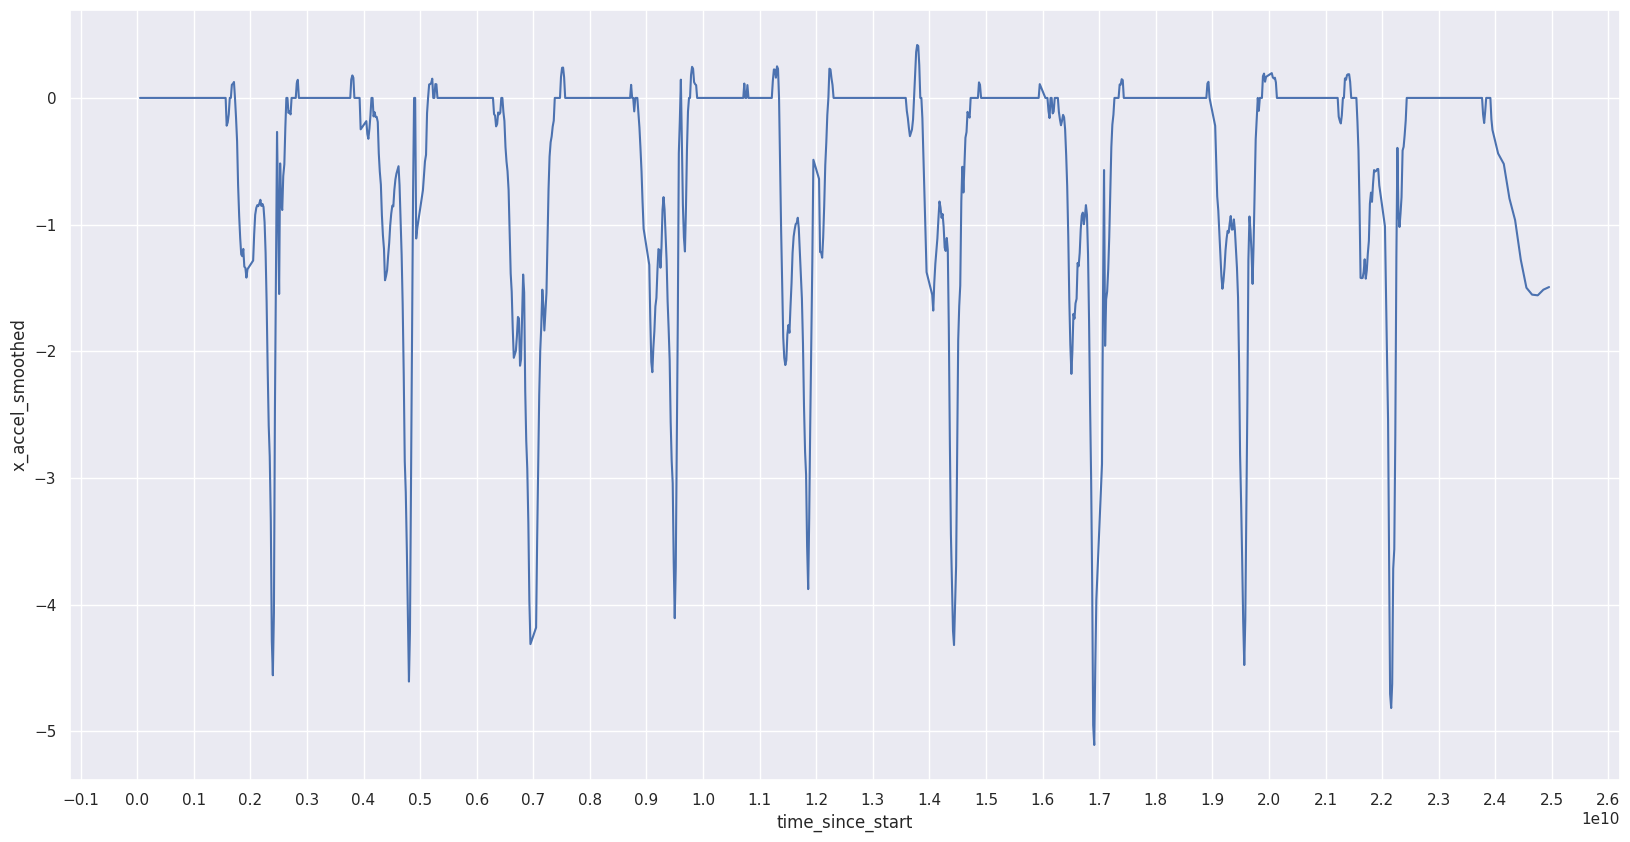

In [8]:
loc = plticker.MultipleLocator(base=1000000000)
sns.set(rc={'figure.figsize':(20,10)})

_tmp = data[data['identifier'] == '25-06-2023 09:50:26']

axes = sns.lineplot(y='x_accel_smoothed', x='time_since_start', data=_tmp)
axes.xaxis.set_major_locator(loc)

We define the start and the end of each movement in a file called windows.xlsx, that will be used to split the data.

In [9]:
windows = pd.read_excel('{}/windows.xlsx'.format(folder))
windows

,Identifier,From,To,Kind
0,2023-06-24 11:34:11,0.60,0.90,Drive
1,2023-06-24 11:34:11,0.90,1.20,Drive
2,2023-06-24 11:34:11,1.20,1.85,Drive
3,2023-06-24 11:34:11,1.85,2.15,Drive
4,2023-06-24 11:34:11,2.15,2.45,Drive
...,...,...,...,...
188,2023-06-25 09:50:26,1.05,1.30,Backhand
189,2023-06-25 09:50:26,1.30,1.50,Backhand
190,2023-06-25 09:50:26,1.50,1.80,Backhand
191,2023-06-25 09:50:26,1.80,2.05,Backhand


In [10]:
splitted_data = []
for index, row in windows.iterrows():
    d = data[
        (data['identifier'] == row['Identifier'].strftime('%d-%m-%Y %H:%M:%S')) &
        (data['time_since_start'] >= pd.to_timedelta(row['From']*10, unit='S')) &
        (data['time_since_start'] < pd.to_timedelta(row['To']*10, unit='S'))
        ]
    splitted_data.append(d)

print(f'Total movements: {len(splitted_data)}')

Total movements: 193


### Sum up features

We have a really low number of samples to train a model. That's why we should build some features to avoid using a Neural Network model for this time series data.

We're going to use the mean of each attribute for each movement.

In [11]:
numeric_columns = ['xAcceleration', 'yAcceleration', 'zAcceleration', 'pitch', 'yaw', 'roll', 'xRotation', 'yRotation', 'zRotation']
columns = numeric_columns + ['kind']

grouped_movement_data = pd.DataFrame([], columns=columns)

for index, movement in enumerate(splitted_data):
    d = []
    for column in numeric_columns:
        d.append(movement[column].mean())
    d.append(movement['kind'].iloc[0])
    grouped_movement_data = pd.concat([grouped_movement_data, pd.DataFrame([d], columns=columns)], ignore_index=True)

In [ ]:
grouped_movement_data.groupby('kind')['kind'].hist()

### Split data into train and test sets

We're using the method **train_test_split** from **sklearn.model_selection** to automatically select the train and test sets from the whole data. It shuffles the samples and select a given percentage for testing.

<Axes: >

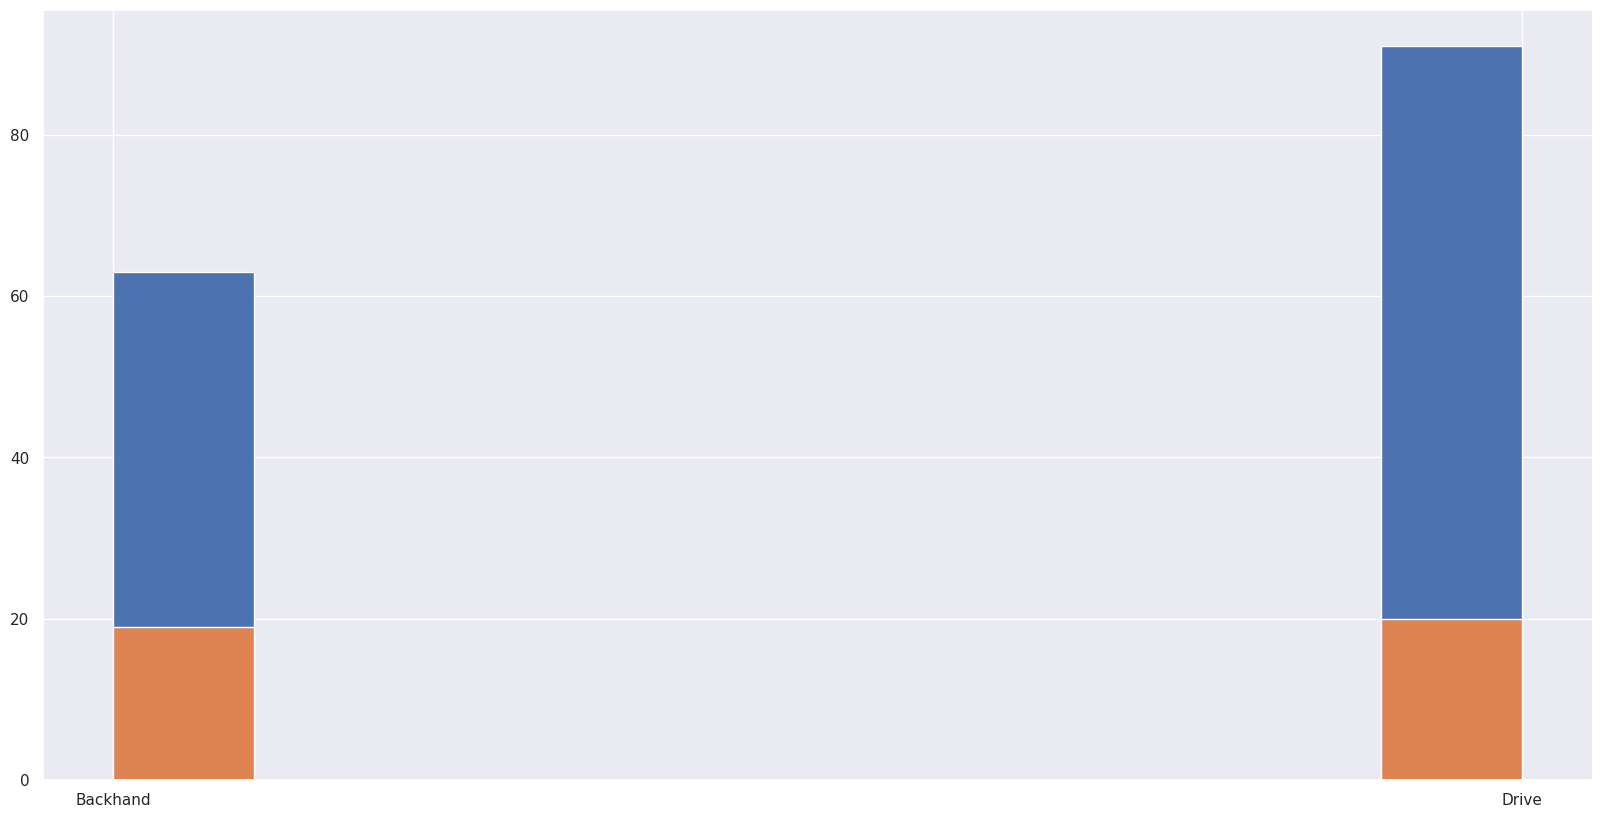

In [19]:
X_train, X_test, y_train, y_test = train_test_split(grouped_movement_data[numeric_columns], grouped_movement_data['kind'], test_size=0.2)
y_train.hist()
y_test.hist()

## Build the model

We're going to check the accuracy given from different algorithms: kNN, SVC and Decision Tree.

In [21]:
# kNN model
nbrs = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
y_pred = nbrs.predict(X_test)

print(f'kNN gives an accuracy of {accuracy_score(y_test, y_pred)*100}%')

kNN gives an accuracy of 100.0%


In [22]:
# SVC model
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(f'SVC gives an accuracy of {accuracy_score(y_test, y_pred)*100}%')

SVC gives an accuracy of 100.0%


Decision Tree gives an accuracy of 100.0%


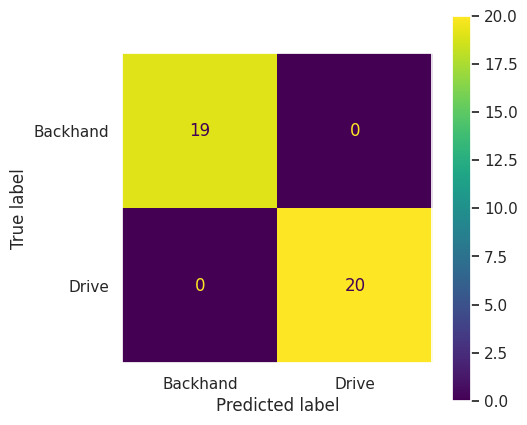

In [24]:
# Decision Tree model
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_probab = tree.predict_proba(X_test)

accuracy_score(y_test, y_pred)
print(f'Decision Tree gives an accuracy of {accuracy_score(y_test, y_pred)*100}%')

cm = confusion_matrix(y_test, y_pred, labels=tree.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

## Conclusion

All three models result in an accuracy near the 100%. Features selected to build these models are classifying correctly each tennis stroke.